<a href="https://colab.research.google.com/github/dan-a-iancu/Data-Analytics-and-AI/blob/master/Pricing_Bottlenecks_and_Flexibility/Prescriptive_Analytics_at_Prosche_Motors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prosche Motors Mini-case**



## **Description**
Prosche Motors is a European company that designs, manufactures and sells electric cars. You have just been appointed as the new COO and are in charge of handling some delicate issues around the production and shipment of a new model nicknamed Tycoon, a highly customizable electric roadster aimed to compete with the company's rivals in the North-American market. In this mini-case, we will focus on the company's operations during the first quarter of next year. Figure 1 below depicts a brief schematic of the supply chain for the Tycoon.

<p align="center">
<img src="https://raw.githubusercontent.com/dan-a-iancu/Data-Analytics-and-AI/master/Pricing_Bottlenecks_and_Flexibility/Figures/Tycoon_supply_chain.png" width="600"/>
</p>

**Production.** Prosche manufactures a bare-bones version of the Tycoon at its facilities in **Zuffe** and **Leip**. Table 1 provides an overview of the production capacities and costs in these facilities. Zuffe is a large, modern facility whereas Leip is a smaller and slightly older facility, with a lower capacity and a higher per-unit cost. The costs are different at the facilities, due to sourcing and transporting the necessary materials and components (such as batteries, rare minerals, etc.) and the different energy and labor market conditions.
<p align="center">
<img src="https://raw.githubusercontent.com/dan-a-iancu/Data-Analytics-and-AI/master/Pricing_Bottlenecks_and_Flexibility/Figures/Table1.png" width="450"/>
</p>

**Customization process.** From the facilities, the cars are then transported to three special-purpose centers nicknamed **C1**, **C2** and **C3**, where they undergo customization to fit the requirements of the clients. Table 2 displays the per-unit costs involved in handling and transporting cars from factories to customization centers, which heavily depend on the precise origin and destination. Each customization center has been designed to be as flexible as possible, with processes capable of handling multiple types of configurations. However, due to the highly specialized nature of the designs, the centers must rely heavily on manual labor and can only handle a limited number of units each quarter, at fairly high costs. The costs and capacities are recorded in Table 3.
<p align="center">
<img src="https://raw.githubusercontent.com/dan-a-iancu/Data-Analytics-and-AI/master/Pricing_Bottlenecks_and_Flexibility/Figures/Tables2-3.png" width="600"/>
</p>

**Retail Clients.** Prosche has received pre-orders for the coming quarter from four major retail clients, code-named OO, FL, SH, and WW. Each client has specific requests for customization and is located in a very different region, which means that Prosche will incur very different costs when customizing and transporting the cars to their final destinations. The costs are recorded in Table 4, for every customization center and every retailer. The pre-orders placed by the clients and the per-unit prices paid to Prosche vary substantially and are recorded in Table 5.
<p align="center">
<img src="https://raw.githubusercontent.com/dan-a-iancu/Data-Analytics-and-AI/master/Pricing_Bottlenecks_and_Flexibility/Figures/Tables4-5.png" width="600"/>
</p>

**Rationing Supply.** Prosche has been facing severe shortages in the supply of key components, so for the past few quarters it was never able to meet all the pre-orders it received. __Customers only pay for the orders that are filled,__ but to avoid angering the clients, the outgoing COO had used __a specific policy to handle rationing: each client would receive enough orders to ensure their fill rate (i.e., the ratio of shipments received to pre-orders placed) exceeds some required threshold__, which management would usually set based on discussions. Historically, the threshold was 50%, but you are reconsidering that value...

**Data Science Team.** Your data science team implemented an AI model that recommends how many units to produce at each manufacturing facility and how to customize and ship these to clients. The team was unsure how to handle rationing, so they are leaving some choices up to you!

<font color=blue>**Your task is to evaluate the team's model and its usefulness in informing some important decisions...**</font>


_____
# <font color=blue>**Part 1: Making sense of the AI model's output**</font>
The following code will create and run an AI model with the following specs:
 - maximize the gross profit for the quarter
 - meet all the physical constraints (e.g., capacities at factories and centers)
 - for any client, do not ship more than the client pre-orders
 - no requirements are imposed on the fill rates achieved at each client.

Based on the outputs below, please address the following questions:
<font color=blue><br>
**Q1. Does the production and shipment plan treat the clients “fairly”?** _(please answer in the poll)_<br>
**Q2. Does the plan make “practical” sense?** _(please answer in the poll)_
 </font>


In [1]:
print('\nInstalling a few useful packages...\n')

###############################################################################
# INCLUDING ALL THE OVERHEAD HERE (READING FILES, etc etc)

# Ignore useless some warnings
import warnings
warnings.filterwarnings('ignore')  # ignore warnings and messages during import

# Python ≥3.5 is required
import sys

# import numpy
import numpy as np
import urllib.request  # for file downloading

# Import pandas for data-frames
import pandas as pd
pd.options.display.max_rows = 15
pd.options.display.float_format = "{:,.2f}".format

from IPython.display import display

# Make sure Matplotlib runs inline, for nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.ticker as ticker

# install Gurobi (our linear optimization solver)
!pip install -i https://pypi.gurobi.com gurobipy
from gurobipy import *

# install the latest version of seaborn for nicer graphics
#!pip install --prefix {sys.prefix} seaborn==0.11.0  &> /dev/null
import seaborn as sns

# resume warning
#warnings.filterwarnings('default')

########################
# Download the entire data as an Excel file from Github

url_Excel = 'https://raw.githubusercontent.com/dan-a-iancu/Data-Analytics-and-AI/master/Pricing_Bottlenecks_and_Flexibility/Prosche_Motors_Data.xlsx?raw=true'
local_file = "Prosche_Motors_Data.xlsx"   # name of local file where you want to store the downloaded file
urllib.request.urlretrieve(url_Excel, local_file)    # download from website and save it locally

########################
# SET UP DATAFRAMES
factoriesDF = pd.read_excel("Prosche_Motors_Data.xlsx", sheet_name = "Factories", index_col=0)
costsFactoriesToCentersDF = pd.read_excel("Prosche_Motors_Data.xlsx", \
                                    sheet_name = "Factories_to_Centers", index_col=0)
customizationCentersDF = pd.read_excel("Prosche_Motors_Data.xlsx", sheet_name = "Customization_Centers", index_col=0)
retailersDF = pd.read_excel("Prosche_Motors_Data.xlsx", sheet_name = "Retailer_Preorders", index_col=0)
costsCentersToRetailersDF = pd.read_excel("Prosche_Motors_Data.xlsx", \
                              sheet_name = "Centers_to_Retailers", index_col=0)

# Create useful lists with the factories, centers, clients
# Calculate some useful lists: the factories, the customization centers, the clients
factories = list( factoriesDF.index )              # the list of factories
centers = list( customizationCentersDF.index )     # the list of customization centers
retailers = list( retailersDF.index )              # the list of retailers

########################
# USEFUL FUNCTIONS
# A function that generates and returns a model like the one in **Q1**
def create_model_like_in_Q1(use_custom_demands=False, custom_demand_dict={}):
    # empty Gurobi model
    m = Model("Prosche Motors Supply Chain Model")

    # Decision variables
    # decision variables for how much to ship from each factory to each customization center
    factoriesToCenters = m.addVars( factories, centers , name = "Ship")

    # decision variables for how much to ship from each customization center to each client
    centersToRetailers = m.addVars( centers, retailers , name="Ship")

    # Objective
    ### REVENUES

    # calculate how much each retailer receives
    retailerReceipts = {}
    for r in retailers:
        retailerReceipts[r] = quicksum( centersToRetailers[c,r] for c in centers )

    # calculate revenues
    revenues = quicksum( retailerReceipts[r] * retailersDF.loc[r,"Price"] for r in retailers )

    ### COSTS
    # there are four terms:
    # - production costs (at factories)
    prodCost = quicksum( factoriesToCenters[f,c] * factoriesDF.loc[f,"Cost"]\
                        for f in factories for c in centers )

    # - handling & transportation costs factories to customization centers
    transCost_FC = quicksum( factoriesToCenters[f,c] * \
                            costsFactoriesToCentersDF.loc[f,c] for f in factories for c in centers )

    # - customization cost (incurred at the customization centers)
    customizationCost = quicksum( centersToRetailers[c,r] * \
                                 customizationCentersDF.loc[c,"Staffing_Cost"] \
                                 for c in centers for r in retailers )

    # - transportation costs customization centers to retail stores
    transCost_CR = quicksum( centersToRetailers[c,r] * \
                            costsCentersToRetailersDF.loc[c,r] for c in centers for r in retailers )

    # total costs
    totalCost =  prodCost + transCost_FC + customizationCost + transCost_CR     # total cost is the sum

    # gross profit
    gross_profit = revenues - totalCost

    # set the objective: maximize gross profit
    m.setObjective( gross_profit, GRB.MAXIMIZE )

    # Constraints
    constraints = {}  # will store all the constraints

    # capacity constraints due to production at each factory
    constraints["factory_cap"] = {}
    for f in factories :
        constraints["factory_cap"][f] = \
        m.addConstr( quicksum(factoriesToCenters[f,c] for c in centers) \
                    <= factoriesDF.loc[f,"Capacity"], name = "Cap_" + f)

    # capacity constraints at customization centers
    constraints["center_cap"] = {}
    for c in centers :
        constraints["center_cap"][c] = \
        m.addConstr( quicksum(centersToRetailers[c,r] for r in retailers) \
                    <= customizationCentersDF.loc[c,"Capacity"], name = "Cap_" + c)

    # flow conservation at each customization center: cars going in = cars going out
    for c in centers :
        m.addConstr( quicksum(factoriesToCenters[f,c] for f in factories) == \
                            quicksum(centersToRetailers[c,r] for r in retailers), name = "Flow_cons_" + c )

    # cannot ship more than pre-orders at each store
    constraints["sales_cap"] = {}
    if use_custom_demands:
        # using custom demands, specified in a dictionary
        for r in retailers :
            constraints["sales_cap"][r] = \
            m.addConstr( retailerReceipts[r] <= custom_demand_dict[r], name = "Demand_" + r)

    else:
        # using the default pre-orders in the case
        for r in retailers :
            constraints["sales_cap"][r] = \
            m.addConstr( retailerReceipts[r] <= retailersDF.loc[r,"Pre-orders"], name = "Preorder_" + r)

    # return the model, the decision variables and the formula for the objective
    return m, factoriesToCenters, centersToRetailers, retailerReceipts, gross_profit,\
    constraints

########################
# A function that calculates the gross profit for a given shipment plan specified with Gurobi variables
# - to compare this gross profit to Q1, set 'compare_to_Q1 = True'
# - to also calculate and print information about the solution, set 'interpret_solution = True'
def calculate_profit_and_compare_Q1(factoriesToCenters, centersToRetailers, retailerReceipts, \
                                    compare_to_Q1, interpret_solution):
    # revenues
    revenue = sum( centersToRetailers[c,r].X * retailersDF.loc[r,"Price"] \
                      for c in centers for r in retailers )

    # - production costs (at factories)
    prodCost = sum( factoriesToCenters[f,c].X * factoriesDF.loc[f,"Cost"] \
                       for f in factories for c in centers )

    # - handling & transportation costs factories to customization centers
    transCost_FC = sum( factoriesToCenters[f,c].X * costsFactoriesToCentersDF.loc[f,c] \
                            for f in factories for c in centers )

    # - customization cost (incurred at the customization centers)
    customizationCost = sum( centersToRetailers[c,r].X * customizationCentersDF.loc[c,"Staffing_Cost"] \
                            for c in centers for r in retailers )

    # - transportation costs customization centers to retail stores
    transCost_CR = sum( centersToRetailers[c,r].X * costsCentersToRetailersDF.loc[c,r] \
                       for c in centers for r in retailers )

    # gross profit
    profit =  revenue - (prodCost + transCost_FC + customizationCost + transCost_CR)

    # print
    print(f"Gross profit: {profit:,.0f}.")
    if (compare_to_Q1):
        print(f"Profit change compared to Q1: {(profit/gross_profit_Q1-1.0)*100:.1f}%.")

    # interpret the solution if desired
    if interpret_solution :
        print('{:<50}\nNumber of units produced at the factories:'.format("="*50))
        for f in factories:
            print("   {:<6} : {:<5,.0f} (capacity was: {:<5,.0f})".\
                  format(f, sum(factoriesToCenters[f,c].X for c in centers), \
                  factoriesDF["Capacity"][f]))

        # shipping factories to centers
        print("{:<50s}\nNumber of units shipped from factories to customization centers:".format("="*50))
        for f in factories :
            for c in centers :
                print("   {:<5s} to {:<3s} : {:,.0f}".format(f,c,factoriesToCenters[f,c].X))

        # processing at customization centers
        print("{:<50s}\nNumber of units processed at customization centers:".format("="*50))
        for c in centers:
            print("   {:<2s} : {:<5,.0f} (capacity was: {:<5,.0f})".\
                  format(c,sum( centersToRetailers[c,r].X for r in retailers), \
                  customizationCentersDF["Capacity"][c]))

        # shipping from centers to retailers
        print("{:<50s}\nNumber of units shipped from customization centers to clients:".format("="*50))
        for c in centers :
            for r in retailers :
                print("   {:<2s} to {:<2s} : {:,.0f}".format(c,r,centersToRetailers[c,r].X))

        # pre-orders fulfilled at each retailer
        print("{:<50}\nFilled orders and fill rates at clients:".format("="*50))
        for r in retailers:
            print("   {:<2s} : {:<5,.0f} orders filled out of {:<5,.0f}, i.e., fill rate of {:<4,.1f} %."\
                  .format(r,retailerReceipts[r].getValue(),\
                          retailersDF["Pre-orders"][r], \
                          retailerReceipts[r].getValue()/retailersDF.loc[r,"Pre-orders"]*100))

###############################################################################
#@markdown **Create an AI model with the specs above**
print('\nCreating an AI Model to optimize the operations...\n')

m_Q1, factoriesToCenters_Q1, centersToRetailers_Q1, retailerReceipts_Q1, gross_profit_Q1, constr_Q1 = \
       create_model_like_in_Q1()

# Below, we are adding a mock fill rate so that we get the same solution as in Q2
m_Q1.setParam('OutputFlag',0)
m_Q1.setParam('Seed', 42)  # set random seed to make sure we get same thing in Q2
for r in retailers :
    m_Q1.addConstr( retailerReceipts_Q1[r] / retailersDF["Pre-orders"][r] >= 0.0)

m_Q1.optimize()
print('Solved the optimization AI Model. Here is the recommendation:\n')

calculate_profit_and_compare_Q1(factoriesToCenters_Q1, centersToRetailers_Q1, retailerReceipts_Q1, \
                                compare_to_Q1=False, interpret_solution=True)

gross_profit_Q1 = m_Q1.objVal


Installing a few useful packages...

Looking in indexes: https://pypi.gurobi.com

Creating an AI Model to optimize the operations...

Restricted license - for non-production use only - expires 2025-11-24
Solved the optimization AI Model. Here is the recommendation:

Gross profit: 33,625,000.
Number of units produced at the factories:
   Zuffe  : 5,000 (capacity was: 5,000)
   Leip   : 0     (capacity was: 2,000)
Number of units shipped from factories to customization centers:
   Zuffe to C1  : 2,000
   Zuffe to C2  : 2,200
   Zuffe to C3  : 800
   Leip  to C1  : 0
   Leip  to C2  : 0
   Leip  to C3  : 0
Number of units processed at customization centers:
   C1 : 2,000 (capacity was: 2,000)
   C2 : 2,200 (capacity was: 2,200)
   C3 : 800   (capacity was: 3,300)
Number of units shipped from customization centers to clients:
   C1 to OO : 100
   C1 to FL : 1,900
   C1 to SH : 0
   C1 to WW : 0
   C2 to OO : 0
   C2 to FL : 600
   C2 to SH : 1,600
   C2 to WW : 0
   C3 to OO : 250
   C3 t

______
# <font color=blue>**Part 2: Navigating tradeoffs**</font>
The following code will create and run an AI model with the following specs:
 - maximize the gross profit for the quarter
 - meet all the physical constraints (e.g., capacities at factories and centers
 - for any client, do not ship more than the client pre-orders
 - for any client, ensure that the fill rate achieved exceeds a minimum level of $f$

The code allows you to change the value of $f$ as you desire, but you can also run the model for all the possible values of $f$.

Based on the outputs below, please address the following questions:
<font color=blue><br>
**Q3. What is the largest fill rate $m$ that could be required?** _(please answer in the poll)_<br>
**Q4. What fill rate $f$ would you require in this case?** _(please answer in the poll)_</font>



Solved the AI model with required fill rate: 50%

Gross profit: 32,950,000.
Profit change compared to Q1: -2.0%.
Number of units produced at the factories:
   Zuffe  : 5,000 (capacity was: 5,000)
   Leip   : 1,350 (capacity was: 2,000)
Number of units shipped from factories to customization centers:
   Zuffe to C1  : 2,000
   Zuffe to C2  : 850
   Zuffe to C3  : 2,150
   Leip  to C1  : 0
   Leip  to C2  : 1,350
   Leip  to C3  : 0
Number of units processed at customization centers:
   C1 : 2,000 (capacity was: 2,000)
   C2 : 2,200 (capacity was: 2,200)
   C3 : 2,150 (capacity was: 3,300)
Number of units shipped from customization centers to clients:
   C1 to OO : 900
   C1 to FL : 1,100
   C1 to SH : 0
   C1 to WW : 0
   C2 to OO : 0
   C2 to FL : 1,400
   C2 to SH : 800
   C2 to WW : 0
   C3 to OO : 1,600
   C3 to FL : 0
   C3 to SH : 0
   C3 to WW : 550
Filled orders and fill rates at clients:
   OO : 2,500 orders filled out of 5,000, i.e., fill rate of 50.0 %.
   FL : 2,500 orders 

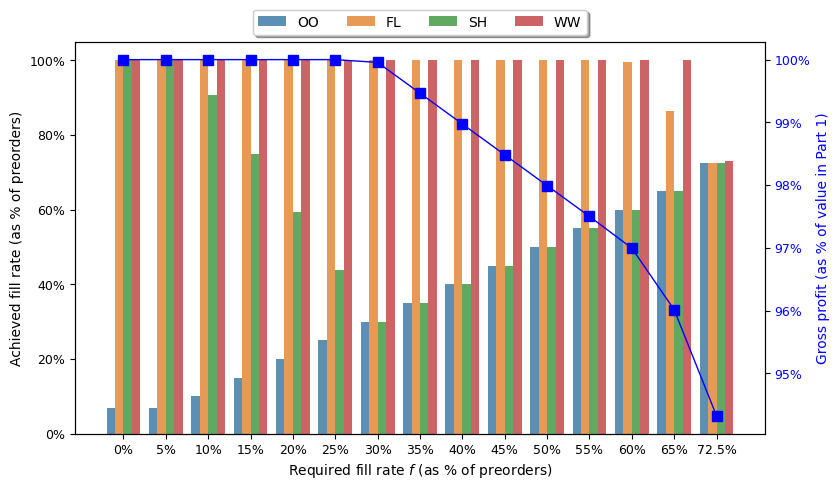

In [2]:
#@markdown **Run the AI model with a given required fill rate**

#@markdown Choose (or type) the required fill rate $f$, as a percentage:
required_fill_rate_f = "50" #@param [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]{allow-input: true}
min_fill_rate = float(required_fill_rate_f)/100

#@markdown Choose whether to see a plot for many values of this required fill rate $f$ (0%-100%):
plot_all_required_fill_rates = True #@param {type: "boolean"}

############ SINGLE MODEL WITH GIVEN FILL RATE
# Create a model like the one in Q1
m_Q2, factoriesToCenters_Q2, centersToRetailers_Q2, retailerReceipts_Q2, gross_profit_Q2, constr_Q2 = \
       create_model_like_in_Q1()

m_Q2.setParam('OutputFlag',0)  # silent
m_Q2.setParam('Seed', 42)  # set random seed to make sure we get same thing in Q2
m_Q2.optimize()  # run once, just in case (get the Q1 value)
gross_profit_Q1 = m_Q2.objVal

# Constrain the fill rate at each retailer
fill_rate_constraint = {}  # store the fill rate constraints in a dictionary, to make it easy to recall them
for r in retailers :
    fill_rate_constraint[r] = \
    m_Q2.addConstr( retailerReceipts_Q2[r] / retailersDF["Pre-orders"][r] >= min_fill_rate)

m_Q2.optimize()
print(f'\nSolved the AI model with required fill rate: {min_fill_rate*100:.0f}%\n')

if m_Q2.status in [GRB.INFEASIBLE, GRB.INF_OR_UNBD]:
    # the model is infeasible
    print("It is infeasible to achieve this required fill rate at all retailers.")

elif m_Q2.status==GRB.OPTIMAL:
    # the model was solved to optimality
    # Print the gross profit and the difference from Q1
    calculate_profit_and_compare_Q1(factoriesToCenters_Q2, centersToRetailers_Q2, retailerReceipts_Q2, \
                                    compare_to_Q1=True, interpret_solution=True)
############################
# IF DESIRED - PLOT FOR ALL FILL RATES
if plot_all_required_fill_rates:

      # details about the plot
      # Powerpoint settings
      fig_width = 10.5
      fig_height = 5.0
      fontsize_labels = 12
      fontsize_ticks = 10
      linewidth = 1.0

      # Colab settings
      fig_width = 8.5
      fig_height = 5.0
      fontsize_labels = 10
      fontsize_ticks = 9
      linewidth = 1.0

      # whether to plot the profit as % of Q1 or the the losses relative to Q1
      plot_losses = False

      # set up values for the fill rate (in percentage terms)
      inc = 5.0
      end_value = 72.5  # the last possible value
      fill_rate_vals = list(np.arange(0,np.floor(end_value/inc)*inc,inc)) + [end_value]

      # the objective values and the loss compared to Q1
      objValues = np.zeros(len(fill_rate_vals))

      # a dictionary with a list for each customer, that stores the realized fill rate at that customer
      individual_fillrates = {}
      for r in retailers:
          individual_fillrates[r] = np.zeros(len(fill_rate_vals))

      for i in range(len(fill_rate_vals)):
          # change the fill rate constraint
          for r in retailers :
              fill_rate_constraint[r].setAttr('rhs', fill_rate_vals[i]/100)

          m_Q2.optimize()
          objValues[i] = m_Q2.objVal
          for r in retailers:
              individual_fillrates[r][i] = (retailerReceipts_Q2[r].getValue() \
                                            / retailersDF["Pre-orders"][r])*100

      # create a dataframe with the values of fill rates
      df = pd.DataFrame(individual_fillrates, index=fill_rate_vals)

      # Reset index to keep the x_values in a column
      df = df.reset_index().melt(id_vars=['index'], var_name='Retailer', \
                                value_name='Fill_Rate')

      # Rename the 'index' column to a more meaningful name, if desired
      df.rename(columns={'index': 'Perc_Diff'}, inplace=True)

      fig = plt.figure(figsize=(fig_width, fig_height))
      color1 = 'black'
      ax1 = plt.gca()
      sns.barplot(data=df, x='Perc_Diff', y='Fill_Rate', \
                  #order=["OO", "FL", "WW", "SH"], \
                  hue="Retailer", \
                  alpha=0.8, zorder=1)
      plt.legend(loc='center', bbox_to_anchor=(0.5, 1.05), \
                fancybox=True, shadow=True, ncol=4)

      # customize labels, etc
      xticks = [f"{v:.0f}%" for v in fill_rate_vals if v!=end_value] + \
       [f"{end_value:.1f}%"]
      ax1.set_xticklabels(xticks, fontsize=fontsize_ticks)
      ax1.set_xlabel("Required fill rate $f$ (as % of preorders)", \
                     fontsize=fontsize_labels)
      #ax1.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}%'))

      ax1.set_ylabel('Achieved fill rate (as % of preorders)', \
                color=color1, fontsize=fontsize_labels)  # we already handled the x-label with ax1
      yticks = ax1.get_yticks()
      ax1.set_yticklabels(yticks, fontsize=fontsize_ticks)
      ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}%'))

      #### SECOND PLOT - PROFITS
      color2 = 'blue'
      ax2 = ax1.twinx()
      if plot_losses:
          yvals = 100*(1.0 - objValues/gross_profit_Q1) # loss as % of Q1
          ylabel = 'Profit loss relative to Part 1 (as %)'
      else:
          yvals = 100*(objValues/gross_profit_Q1)  # as % of Q1
          ylabel = 'Gross profit (as % of value in Part 1)'

      # customize y axis
      ax2.plot(yvals, color=color2, linestyle='-', linewidth=linewidth, \
              marker='s', markersize=7.0)
      ax2.set_ylabel(ylabel, color=color2, fontsize=fontsize_labels)
      ax2.tick_params(axis='y', labelcolor=color2, labelsize=fontsize_ticks)
      ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}%'))
      yticks = ax2.get_yticks()
      yticks = [ v for v in yticks if ((v>=0) and (v<=100))]
      plt.tight_layout()
      plt.show()

**Clarification.** If you are visualizing the figure, this shows several pieces of information:
- the **vertical colored bars** correspond to the **left axis and the legend** and show the fill rate actually achieved at each client;
- the <font color=blue>**blue line plot**</font> corresponds to the **right axis** and shows the profit achieved, as a percent of the profit reported in Part 1.

_For instance, when the **minimum required fill rate $m$ is 50%**, the actual fill rates achieved will be 50% at OO, 100% at FL, 50% at SH, 100% at WW, and the profit achieved will be 98% of the profit in Part 1._

______
# <font color=blue>**Part 3: Pricing bottlenecks**</font>
You are considering expanding the capacity of the manufacturing facilities and customization centers, but are unsure where to focus your efforts. The following code will create **an AI model like in Part 1** and use it to determine how the maximum profit achievable changes with the capacities of the facilities. You can also select whether to display a plot visualizing how profits change with the capacity more broadly. Based on the outputs below, please address the following questions:
<font color=blue><br><br>
**Q5. If you were to increase the capacity at** one **facility, which would you choose?** _(please answer in the poll)_<br><br>
_Looking back at Parts 1-3, some questions for brainstorming:_<br>
**Do you already use such models to inform decisions in your organization?**<br>
**If yes, what kind of decisions?**<br>
**If not, what are some decisions that could benefit from this and what are barriers to implementing such AI models?**
</font>


Changing the capacity at Zuffe by +1 (so total capacity becomes 5,001 units) changes the profit compared to Part 1 by: +3,000 EUR.
Changing the capacity at Leip  by +1 (so total capacity becomes 2,001 units) changes the profit compared to Part 1 by: +0 EUR.
Changing the capacity at C1    by +1 (so total capacity becomes 2,001 units) changes the profit compared to Part 1 by: +6,000 EUR.
Changing the capacity at C2    by +1 (so total capacity becomes 2,201 units) changes the profit compared to Part 1 by: +1,500 EUR.
Changing the capacity at C3    by +1 (so total capacity becomes 3,301 units) changes the profit compared to Part 1 by: +0 EUR.


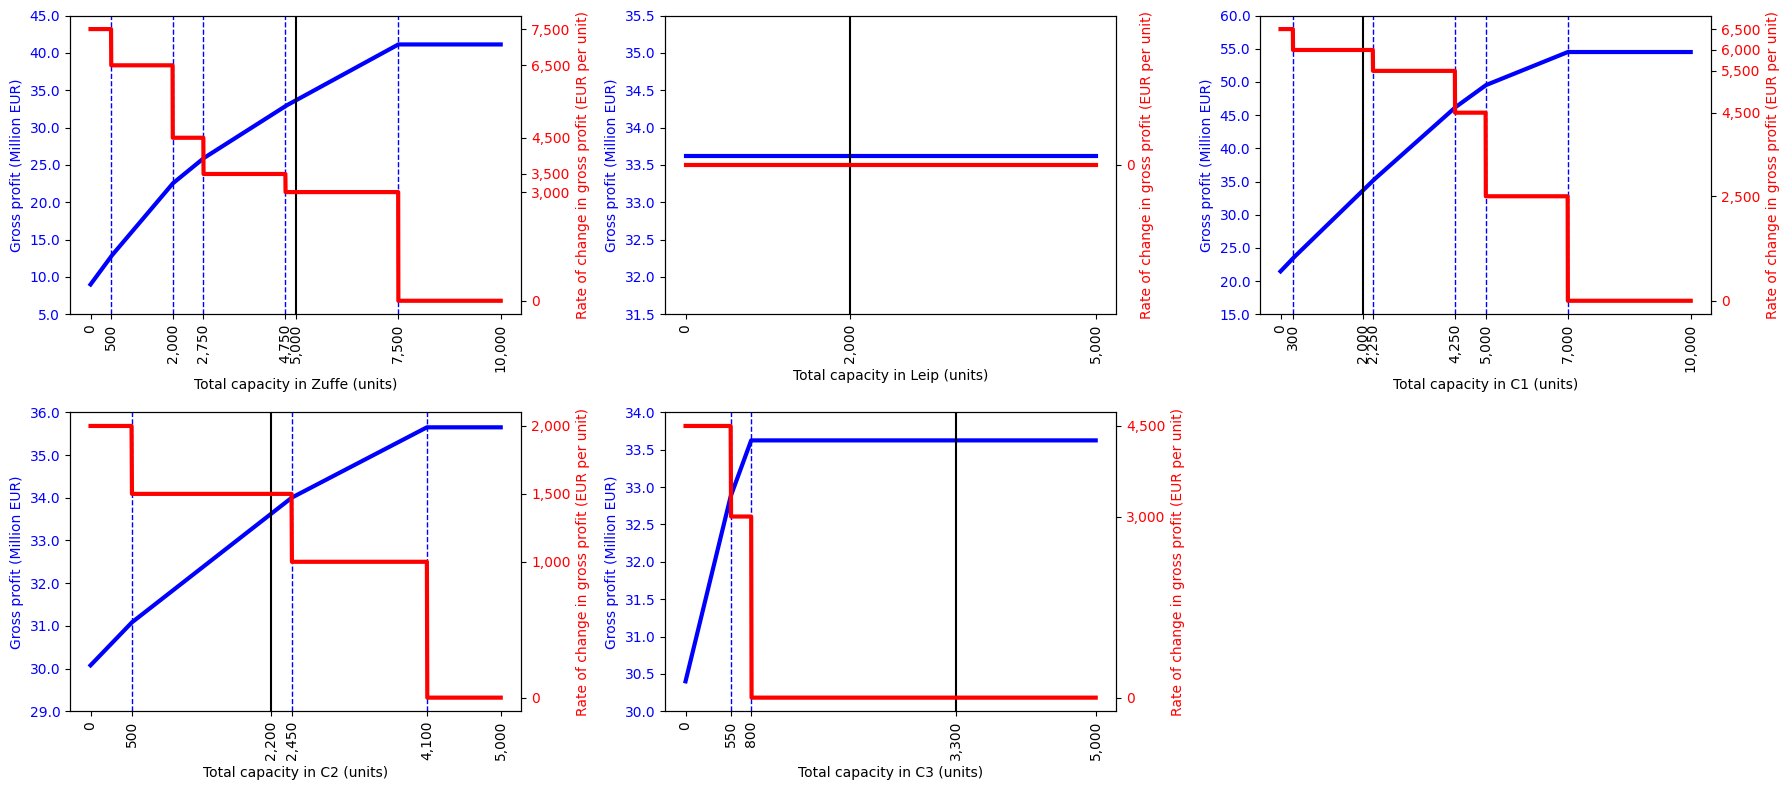

In [3]:
#@markdown **Run the AI model to quantify the impact of extra capacity**

#@markdown Select the facility for which to change capacity (**"All"** will check all facilities):
facility = 'All' #@param ["All", "Zuffe", "Leip", "C1", "C2", "C3"] {allow-input: false}

#@markdown Type by how much to change the capacity at the facility (in units; positive or negative changes allowed):
capacity_change = 1 #@param {type:"number"}

#@markdown Select whether to see a plot of how the gross profit changes with the capacity in a wider range
plot_profit_with_capacity = True #@param {type:"boolean"}

# #@markdown Select whether to see a plot for wider changes (if so, you can customize the plot below...)
# #@markdown (If plotting) Select whether to plot the **profit** or the **change in profit** relative to Part 1)
# display_profit_changes = True #@param {type:"boolean"}
#display_rate_of_change = True #@param {type:"boolean"}

display_profit_changes = False
display_rate_of_change = True

# Create a model like the one in Q1, save it and save the objective
m, factoriesToCenters, centersToRetailers, retailerReceipts, gross_profit, constr = \
       create_model_like_in_Q1()
m.setParam('OutputFlag',0)  # run silently
m.optimize()
gross_profit_Q1 = m.objVal  # save objective

# figure out which facilities to check
if facility=="All":
    which_facilities = factories + centers
else:
    which_facilities = [facility]

for facility in which_facilities:
    if facility in factories:
        relevant_constr = constr["factory_cap"][facility]
        new_capacity = factoriesDF["Capacity"][facility] + capacity_change

    elif facility in centers:
        relevant_constr = constr["center_cap"][facility]
        new_capacity = customizationCentersDF["Capacity"][facility] + capacity_change

    # make the change
    relevant_constr.setAttr('rhs', new_capacity)

    # rerun the optimization
    m.optimize()

    if m.status in [GRB.INFEASIBLE, GRB.INF_OR_UNBD]:
        # the model is infeasible
        print(f"Changing the capacity at {facility:<5s} by {capacity_change:+d} (so total capacity becomes {new_capacity:,.0f} units) makes the AI model infeasible.")

    elif m.status==GRB.OPTIMAL:
        # the model was solved to optimality
        print(f"Changing the capacity at {facility:<5s} by {capacity_change:+d} (so total capacity becomes {new_capacity:,.0f} units) changes the profit compared to Part 1 by: {m.objVal - gross_profit_Q1:+,.0f} EUR.")

    # revert the change
    relevant_constr.setAttr('rhs', new_capacity - capacity_change)

#######################################################
if plot_profit_with_capacity:

    # determine how many plots are needed
    ## first set of settings are useful for Powerpoint
    # fontsize = 20
    # fig_width = 20
    # fig_height = 10
    ## second set is useful for Colab
    fontsize = 10
    fig_width = 6
    fig_height = 4

    ### OPTIONS ABOUT PLOTTING
    plot_capacity_diffs = False        # True: uses capacity differences on x-axis
    show_only_xticks_changes = True   # true: show only x ticks where shadow price changes
    mark_every = 200                  # if showing many ticks, mark only every couple of them

    num_figs = len(which_facilities)  # how many figures total
    figures_per_row = 3               # how many plots per row
    num_cols = (1 if num_figs==1 else figures_per_row)
    num_rows = int(np.ceil(num_figs/num_cols))

    # create one big figure of appropriate size
    fig = plt.figure(figsize=(fig_width*num_cols, fig_height*num_rows))

    # loop through all figures
    for f in range(num_figs):

        # pick up the right facility
        facility = which_facilities[f]

        # figure out the correct constraint to change and save the original value
        if facility in factories:
            con_changing = constr["factory_cap"][facility]
            orig_cap = factoriesDF["Capacity"][facility]

        elif facility in centers:
            con_changing = constr["center_cap"][facility]
            orig_cap = customizationCentersDF["Capacity"][facility]

        # set up values for the capacity increase
        if facility in ["Zuffe", "C1"]:
            max_cap = 10000
        else:
            max_cap = 5000
        inc_cap = 5
        cap_values = np.arange(0,max_cap+inc_cap,inc_cap)

        # the objective values and the loss compared to Q1
        objValues = np.zeros(len(cap_values))
        change_Q1 = np.zeros(len(cap_values))
        shadow_prices = np.zeros(len(cap_values))

        # loop through all capacity values
        for i in range(len(cap_values)):
            con_changing.setAttr('rhs', cap_values[i])  # change RHS
            m.optimize()    # solve model

            # store everything needed
            objValues[i] = m.objVal/1e6
            #change_Q1[i] = (objValues[i]/gross_profit_Q1 - 1.0)*100
            change_Q1[i] = objValues[i] - gross_profit_Q1/1e6
            shadow_prices[i] = con_changing.Pi

        # SETTINGS FOR THE PLOT
        # plot the gross profits changes
        #palette = sns.color_palette('tab10')
        palette = ["blue", "red"]
        color1 = palette[0]
        color2 = palette[1]

        # select the correct subplot and get its axes
        plt.subplot(num_rows,num_cols,f+1)
        ax1 = plt.gca()

        # figure one what to plot on y
        if display_profit_changes:
            # plot changes in profit
            yvals = change_Q1
            ylabel = "Gross profit change (Million EUR)"
        else:
            # plot actual profit
            yvals = objValues
            ylabel = "Gross profit (Million EUR)"

        # figure out what to have on x
        if plot_capacity_diffs:
            xvals = cap_values - orig_cap  # use the difference from nominal cap as x values
            xlabel = f"Total capacity change in {facility} (units)"
        else:
            xvals = cap_values  # use the full capacity as x values
            xlabel = f"Total capacity in {facility} (units)"

        # do the actual plot
        plt.plot(xvals, yvals, linestyle='solid', linewidth=3, color=color1)

        # customize the plot - x axis
        ax1.set_xlabel(xlabel, fontsize=fontsize)
        ax1.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

        ## figure out which ticks to show on x-axis
        # find the values where there is a change in shadow price
        idx_shadow_price_change = np.where(shadow_prices[0:-1] != shadow_prices[1:])[0]

        if show_only_xticks_changes:
            # ticks at start, end, zero point, and all points where function slope changes
            xticks = [xvals[0]] + list(xvals[cap_values==orig_cap]) + \
             [xvals[v] for v in idx_shadow_price_change] + [xvals[-1]]
        else:
            # all the ticks
            xticks = xvals[0:len(xvals):mark_every]
        plt.xticks(ticks=xticks, rotation=90)
        plt.xticks(fontsize=fontsize)
        ax1.xaxis.grid(False)

        # show a vertical line at all x-values where the profit changes slope
        #  (equivalently, there is a change in shadow price)
        for xcoord in idx_shadow_price_change:
            plt.axvline(xvals[xcoord], linestyle='--', linewidth=1.0, \
                        color=color1)

        # show a solid vertical line at the starting value of the capacity
        plt.axvline(xvals[cap_values==orig_cap], linestyle='-', linewidth=1.5, \
                    color='black')

        # customize the plot - y axis
        plt.ylabel(ylabel, fontsize=fontsize, color=color1)
        ax1.tick_params(axis='y', labelcolor=color1)
        # ax1.yaxis.set_label_coords(0.02,0.5)   # move the y-label
        yticks = np.sort(ax1.get_yticks())
        ax1.set_yticks(yticks)    # add another y-tick at the very top
        plt.yticks(fontsize=fontsize)
        ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}'))
        ax1.yaxis.grid(False)

        # display the shadow prices (if desired)
        if display_rate_of_change:
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            ax2.plot(xvals, shadow_prices, color=color2, linestyle='-', linewidth=3)

            ax2.set_ylabel('Rate of change in gross profit (EUR per unit)', \
                           color=color2, fontsize=fontsize)
            #ax2.yaxis.set_label_coords(0.98,0.5)
            ax2.set_yticks(ticks=np.unique(shadow_prices), labels=np.unique(shadow_prices),\
                           color=color2, fontsize=fontsize)
            ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
            ax2.tick_params(axis='x', labelsize=fontsize)
            ax2.yaxis.grid(False)

        # revert the changes
        con_changing.setAttr('rhs', orig_cap)

    # show the overall plot
    plt.tight_layout()
    plt.show()

**Clarification if you are visualizing the plot.** Each figure displays several items:
- the <font color=blue>**blue plot**</font> corresponds to the **left axis** and shows the gross profit.
- the **<font color=blue>dashed blue vertical lines</font>** mark the points where the slope of the blue line changes.
- the <font color=red>**red plot**</font> corresponds to the **right axis** and shows the rate of change in the profit (i.e., the slope of the blue line).
- the **solid black vertical line** marks the value of the capacity mentioned in the case for that facility.

_____________
# <font color=blue>**Part 4: Quantifying the impact of uncertainty**</font>
Upon further investigation, you have realized that the pre-orders that clients place are not firm. Rather, clients usually provide these as estimates, but the actual orders placed during the quarter often differ from the estimates. **The outgoing COO had enforced the practice that Prosche should always come up with a plan upfront based on the pre-orders, and start producing and shipping the cars to warehouses near the clients before the final orders are confirmed.** If a client's final order were higher than the pre-order, Prosche would decline filling anything extra; and if the final order were lower than the pre-order, Prosche would sell any remaining cars in bulk through a secondary channel, for €65,000 each. Because this uncertainty could have a material impact, you asked the data science team to update its models to capture it. They prepared a **new model** with the following specs:
 - assume that orders can take any value, equally likely, within a percentage $p$ of the pre-orders and use 10,000 scenarios drawn from the corresponding range to simulate the true orders.<br>
 _(For instance, with $p$=10%, true orders at OO could take any value from 4,500 to 5,500, and the model will use 10,000 values drawn randomly from that range to represent the true orders.)_
 - allow examining different levels of uncertainty, by changing $p$ from 0% to 100%.
 - respect the outgoing COO's rule of having an upfront production and shipment plan.
 - for each level of uncertainty $p$, determine a plan that maximizes the mean gross profit achieved over the 10,000 scenarios.
 - allow for the possibility of shipping more than the pre-orders at a client.
 - meet all the physical constraints.


In addition, the team also included the option - for benchmarking purposes - of **just using the ordering plan you determined in Part 1**.

Based on the outputs below, please address the following questions:
<font color=blue><br>
**Q6. How would you characterize the impact of uncertainty?** _(please answer in the poll)_<br>
**Q7. Would you prefer the new plan or the plan from Part 1?** _(please answer in the poll)_</font>

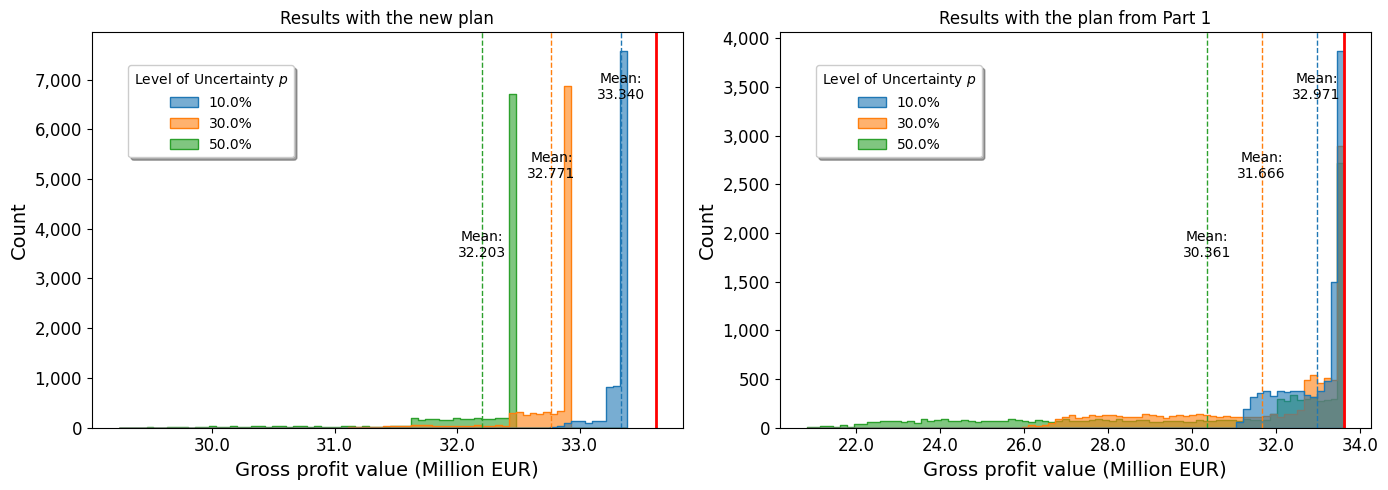

In [4]:
#@markdown **Run the AI model to quantify the impact of uncertainty**

#@markdown Select the uncertainty level (**"Several"** will choose and plot several levels):
uncertainty_level_p = "Several" #@param ["Several", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"] {allow-input: false}

if uncertainty_level_p=="Several":
    param_values_to_compare = ["0.10", "0.30", "0.50"]
else:
    param_values_to_compare = [f"{float(uncertainty_level_p[:-1])/100:.2f}"]

# #@markdown Select whether to use the **new model** or use the production and shipment plan from Part 1
#which_plan_to_use = 'use_plan_from_Part_1' #@param ["both", "use_new_model", "use_plan_from_Part_1"] {allow-input: false}
which_plan_to_use = 'both'

# also download the file with results
url_results = 'https://raw.githubusercontent.com/dan-a-iancu/Data-Analytics-and-AI/master/Pricing_Bottlenecks_and_Flexibility/results_profits_simul_static_dynamic.csv?raw=true'
local_file_res = "results_profits.csv"   # name of local file where you want to store the downloaded file
urllib.request.urlretrieve(url_results, local_file_res)    # download from website and save it locally

# one row per scenario, two columns for each value of the range parameter (for STATIC/no-flex and DYNAMIC/flex)
filename = "results_profits.csv"
df_results = pd.read_csv(filename)

if which_plan_to_use=="both":
   # first plot will be with the new plan
   plot1 = {}
   plot1["all_cols"] = [f"profits_static_{rho}" for rho in param_values_to_compare]
   plot1["title"] = "Results with the new plan"

   # second plot is with the plan from Part 1
   plot2 = {}
   plot2["all_cols"] = [f"profits_simul_{rho}" for rho in param_values_to_compare]
   plot2["title"] = "Results with the plan from Part 1"

   plots_to_do = [plot1, plot2]  # store both plots in a list

elif which_plan_to_use=="use_plan_from_Part_1":
   plot1 = {}
   plot1["all_cols"] = [f"profits_simul_{rho}" for rho in param_values_to_compare]
   plot1["title"] = "Results with the plan from Part 1"
   plots_to_do = [plot1]    # store in a list

else:
   plot1 = {}
   plot1["all_cols"] = [f"profits_static_{rho}" for rho in param_values_to_compare]
   plot1["title"] = "Results with the new plan"

   # store both plots in a list
   plots_to_do = [plot1]  # store in a list

# choices for the plot
fig_width = 7.0
fig_height = 5.0
font_size = 12.0
font_size_ticks = 12.0
font_size_labels = 14

### CREATE THE FIGURE OF APPROPRIATE OVERALL SIZE
plt.figure(figsize=(len(plots_to_do)*fig_width, fig_height))

# for every necessary plot
for p in range(len(plots_to_do)):
    # choose the right plot
    plt.subplot(1,len(plots_to_do),1+p)

    # assign the needed data
    all_cols = plots_to_do[p]["all_cols"]
    title = plots_to_do[p]["title"]

    melted_df = pd.melt(df_results, value_vars=all_cols, var_name='Uncertainty', value_name='Gross Profit Value')
    melted_df['Gross Profit Value'] /= 1e+6

    palette_choice = 'tab10'
    sns.histplot(data=melted_df, x='Gross Profit Value', hue='Uncertainty', stat="count", kde=False, \
                alpha=0.6, element='step', palette=palette_choice)

    plt.xlabel('Gross profit value (Million EUR)', fontsize=font_size_labels)
    plt.ylabel('Count')
    plt.title(title)
    plt.grid(False)

    # Adjust tick formatting as needed
    ax = plt.gca()
    ax.tick_params(axis='x', labelsize=font_size_ticks)
    ax.tick_params(axis='y', labelsize=font_size_ticks)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    # Update the legend to show proper formatting for the percentages
    legend = ax.get_legend()
    if legend:
        # set a title
        legend.set_title("Level of Uncertainty $p$")

        # format the labels for the legend
        new_labels = [f"{float(label.get_text()[-4:])*100:.1f}%" for label in legend.get_texts()]

        # update the labels
        for text, new_label in zip(legend.get_texts(), new_labels):
            text.set_text(new_label)

    # move the legend
    sns.move_legend(ax, "center left", bbox_to_anchor=(0.05, 0.8), ncol=1, fancybox=True, shadow=True)

    # Calculate means and plot vertical lines
    palette = sns.color_palette(palette_choice)

    for i, group in enumerate(all_cols):
        mean_value = df_results[group].mean()/1e6   # express the mean in millions

        plt.axvline(x=mean_value, color=palette[i], linestyle='--', linewidth=1)
        rho_val = float(group[-4:-1])
        plt.text(mean_value, ax.get_ylim()[1]*(1-rho_val), f'Mean:\n{mean_value:.3f}', color='black', \
                ha='center', va='top')

    # ALSO INCLUDE ONE VERTICAL LIKE FOR THE PROFIT FROM Q1 (0% UNCERTAINTY)
    profits_no_uncertainty = df_results["profits_simul_0.00"].mean()/1e6
    plt.axvline(x=profits_no_uncertainty, color="red", linestyle='-', linewidth=2)
    #plt.text(profits_no_uncertainty, ax.get_ylim()[1]*0.95, f'Mean:\n{mean_value:.2f}', color='black', \
    #          ha='center', va='top')

plt.tight_layout()
plt.show()

**A few clarifications about the plots.**
 - Each figure displays several histograms corresponding to different levels of uncertainty $p$.
 - Each histogram shows the 10,000 values of gross profits achieved in the 10,000 scenarios corresponding to that level of uncertainty $p$.
 - For each histogram, there is a dotted vertical line with the same color that shows the **mean** of the gross profit (i.e., the average of the 10,000 values in the histogram).
 - The <font color=red>**solid red line**</font> shows the gross profit value from Part 1.

_____________
# <font color=blue>**Part 5: Quantifying the benefits of postponement / flexibility / information**</font>
Thinking again about the situation in Part 4, you have come to realize that there may be huge benefits in **being able to postpone the production decisions until the time when the actual orders from clients are known**. In that case, even if the orders differ from the pre-orders, you would be able to react and produce more or less, depending on what is required. The data science team updated its AI model from Part 4 to capture this possibility. The code below allows you to compare **this updated model (with postponement)** with the **new model from Part 4 (without postponement)**.

Based on the outputs below, please address the following questions:
<font color=blue><br>
**Q8. Assuming that the uncertainty level is $p$=30%, what is the value of being able to postpone the production?** _(please answer in the poll)_<br>
**Q9. How does the value of postponement depend on the uncertainty level $p$?** _(please answer in the poll)_<br><br>
_Looking back at Parts 1-3, some questions for brainstorming:_<br>
**Do you already use such models to inform decisions in your organization?**<br>
**If yes, what kind of decisions?**<br>
**If not, what are some decisions that could benefit from this and what are barriers to implementing such AI models?**
</font>


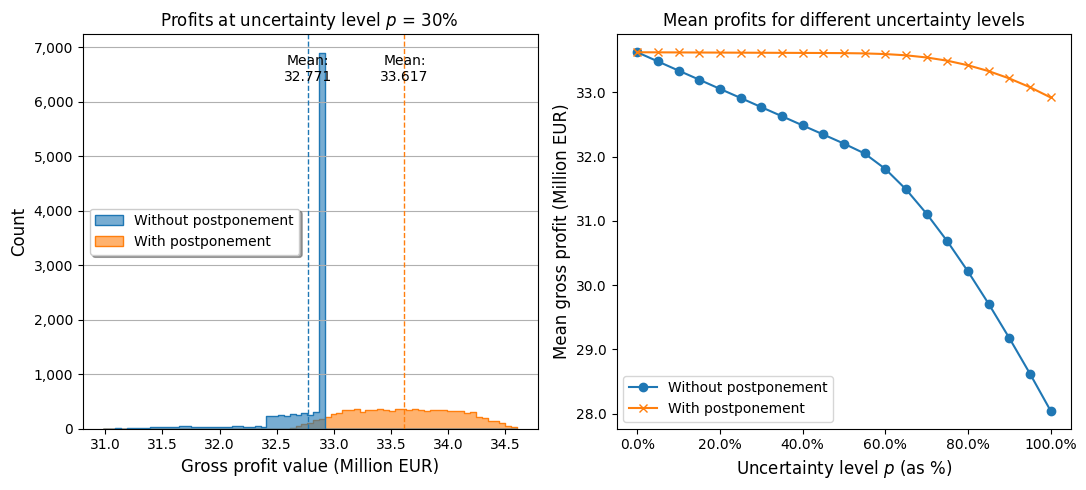

In [5]:
#@markdown **Run the AI model to quantify the impact of uncertainty**

#@markdown Select the uncertainty level:
uncertainty_level_p = "30%" #@param ["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"] {allow-input: false}
param_values_to_compare = [f"{float(uncertainty_level_p[:-1])/100:.2f}"]

compare_the_means = True

# also download the file with results
url_results = 'https://raw.githubusercontent.com/dan-a-iancu/Data-Analytics-and-AI/master/Pricing_Bottlenecks_and_Flexibility/results_profits_simul_static_dynamic.csv?raw=true'
local_file_res = "results_profits.csv"   # name of local file where you want to store the downloaded file
urllib.request.urlretrieve(url_results, local_file_res)    # download from website and save it locally

# one row per scenario, two columns for each value of the range parameter (for STATIC/no-flex and DYNAMIC/flex)
filename = "results_profits.csv"
df_results = pd.read_csv(filename)

all_cols = [f"profits_static_{rho}" for rho in param_values_to_compare] + \
[f"profits_dynamic_{rho}" for rho in param_values_to_compare]

# choices for the plot
fig_width = 11.0
fig_height = 5.0
font_size = 12.0
font_size_ticks = 10.0
font_size_labels = 12

# Create a figure with two subplots
nfigs = (2 if compare_the_means else 1)
fig, axs = plt.subplots(1, nfigs, figsize=(fig_width, fig_height))  # Adjust the size as needed

###### FIRST PLOT: histograms at specific uncertainty level

# Assuming df_results, all_cols_static, and all_labels are defined
melted_df = pd.melt(df_results, value_vars=all_cols, var_name='Type', value_name='Gross Profit Value')
melted_df['Gross Profit Value'] /= 1e+6

############# CREATE THE FIGURE
palette_choice = 'tab10'

# fix the axes choice (subplots returns a scalar if there's a single plot!)
if nfigs > 1:
    ax1 = axs[0]
else:
    ax1 = axs

sns.histplot(data=melted_df, x='Gross Profit Value', hue='Type', stat="count", kde=False, \
             alpha=0.6, element='step', palette=palette_choice, ax=ax1)

# ax1.set_title(f"Gross Profits With and Without Flexibility\nUncertainty Level : {uncertainty_level_p}")
ax1.set_xlabel('Gross profit value (Million EUR)', fontsize=font_size_labels)
ax1.set_ylabel('Count', fontsize=font_size_labels)
ax1.set_title(f"Profits at uncertainty level $p$ = {uncertainty_level_p} ")

# Adjust tick formatting and grids as needed
ax1.tick_params(axis='x', labelsize=font_size_ticks)
ax1.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}'))
ax1.xaxis.grid(False)

ax1.tick_params(axis='y', labelsize=font_size_ticks)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax1.yaxis.grid(True)

# Update the legend to show proper formatting for the percentages
legend = ax1.get_legend()
legend.set_title("")
if legend:
    ### get the original labels
    old_labels = [label.get_text() for label in legend.get_texts()]

    ### format them:
    # if there is a single uncertainty level, don't include it in the label
    new_labels = [("Without postponement" if "static" in label else "With postponement") \
                  for label in old_labels]

    #### for multiple uncertainty levels, can uncomment next section
    ## include the uncertainty level in the label as well
    #  new_labels = [f"{'Without postponement' if 'static' in label else 'With postponement'} ({float(label[-4:])*100:.1f}%)"
    #                for label in old_labels]

    # set the new labels
    for text, new_label in zip(legend.get_texts(), new_labels):
        text.set_text(new_label)

# move the legend
#sns.move_legend(ax1, "center", bbox_to_anchor=(0.5, 1.05), ncol=2, fancybox=True, shadow=True)
sns.move_legend(ax1, "center left", bbox_to_anchor=(0.0, 0.5), ncol=1, fancybox=True, shadow=True)

# Calculate means and plot vertical lines
palette = sns.color_palette(palette_choice)

for i, group in enumerate(all_cols):
    mean_value = df_results[group].mean()/1e6   # express the mean in millions
    ax1.axvline(x=mean_value, color=palette[i], linestyle='--', linewidth=1)
    ax1.text(mean_value, ax1.get_ylim()[1]*0.95, f'Mean:\n{mean_value:.3f}', color='black', \
             ha='center', va='top')

############# SECOND FIGURE (IF NEEDED)
if compare_the_means:

    # get all the uncertainty values in the dataframe
    all_uncertainty_values = np.sort([float(col[-4:]) for col in df_results.columns if "profits_static" in col ])

    means_static = [df_results[f"{'profits_static'}_{rho:.2f}"].mean()/1e6 for rho in all_uncertainty_values ]
    means_dynamic = [df_results[f"{'profits_dynamic'}_{rho:.2f}"].mean()/1e6 for rho in all_uncertainty_values ]

    # Plotting the means for list1
    axs[1].plot(all_uncertainty_values*100, means_static, label='Without postponement', marker='o')  # Add markers for clarity

    # Plotting the means for list2 on the same subplot
    axs[1].plot(all_uncertainty_values*100, means_dynamic, label='With postponement', marker='x')  # Different marker for distinction

    # Customize the subplot
    axs[1].set_title('Mean profits for different uncertainty levels', fontsize=font_size_labels)
    axs[1].set_xlabel('Uncertainty level $p$ (as %)', fontsize=font_size_labels)
    axs[1].legend()

    axs[1].set_xticklabels(all_uncertainty_values*100)
    axs[1].tick_params(axis='x', labelsize=font_size_ticks)
    axs[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}%'))

    axs[1].set_ylabel('Mean gross profit (Million EUR)', fontsize=font_size_labels)
    axs[1].tick_params(axis='y', labelsize=font_size_ticks)
    axs[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}'))

plt.tight_layout()
plt.show()